In [10]:
import skimage
import pandas as pd
import numpy as np

In [7]:
res = pd.read_csv('smFISH_MCT_CZI_Panel_0_spot_table.csv', index_col=0)

/usr/local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
res.head()

,x,y,z,xc,yc,zc,target
0,-28210.492188,-13683.149165,4.626504,-0.002821,-0.001368,0.000001,Fezf2
1,-27077.361985,-13248.334998,5.508578,-0.002708,-0.001325,0.000002,Fezf2
2,-26219.063796,-10448.332011,8.373441,-0.002622,-0.001045,0.000003,Fezf2
3,-25103.189701,-10975.959995,12.656902,-0.002510,-0.001098,0.000004,Fezf2
4,-26265.598028,-9334.573807,9.856035,-0.002627,-0.000933,0.000003,Fezf2


mock up a (1500 x 1500 image)

In [41]:
image = np.zeros((1500, 1500), dtype=int)

Scale the physical coordinates onto the same 1500 x 1500 grid. 

In [42]:
# scale x into (0, 1500)
x = res.xc
x = ((x - x.min()) / (x.max() - x.min())) * 1499

# scale y into (0, 1500)
y = res.yc
y = ((y - y.min()) / (y.max() - y.min())) * 1499

y = np.round(y).astype(int)
x = np.round(x).astype(int)

For every spot detected, add a single count to the pseudo-image

In [46]:
for (yc, xc) in zip(y, x):
    image[yc, xc] += 1    

Clip the image at a max value of 8 (so that many positions take the max)

In [47]:
image[image > 8] = 8

Scale the image into (0, 1)

In [48]:
image = image / image.max()

In [137]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_image(image, **kwargs): 
    f, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(image, **kwargs)

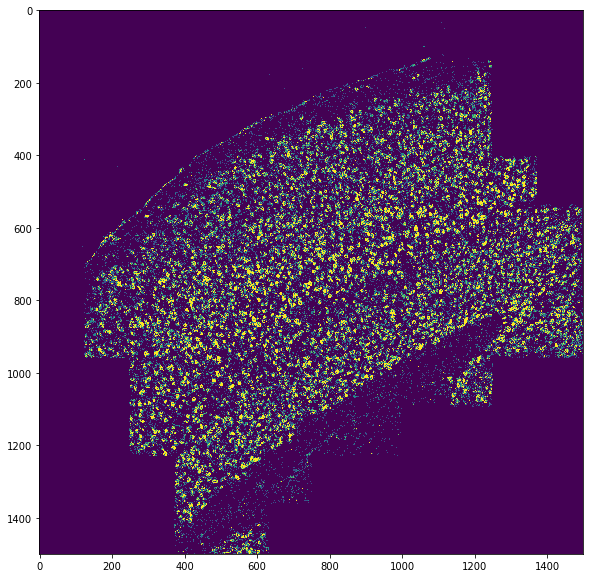

In [50]:
plot_image(image)

In [51]:
from skimage.filters import gaussian

smoothed = gaussian(image, 1)

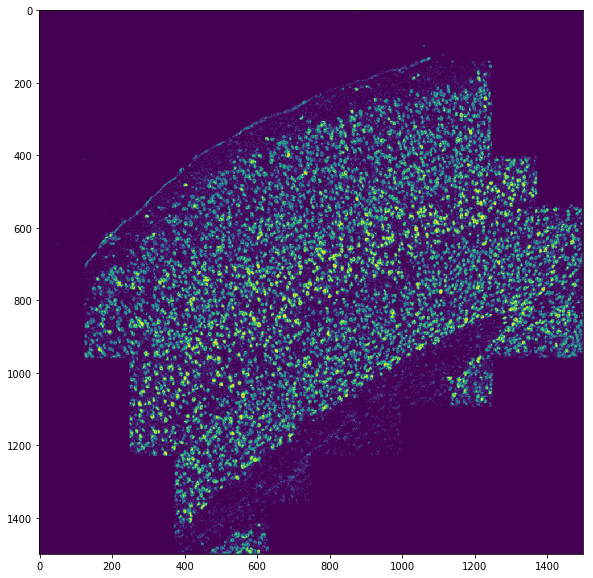

In [135]:
plot_image(smoothed)

Differentiate foreground and background iwth 

In [55]:
from skimage.morphology import watershed
from scipy.ndimage import convolve

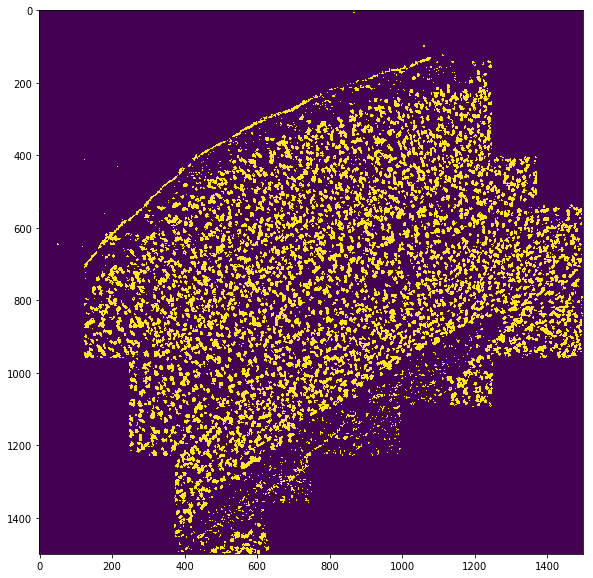

In [136]:
selem = skimage.morphology.disk(31)
selem = selem / selem.sum()
disc = convolve(smoothed, selem)

threshold = smoothed > disc + 0.05

plot_image(threshold)

Create markers and basins from the thresholded image

In [103]:
import scipy.ndimage as ndi
from skimage.measure import label

# distance transform on basins
dist = ndi.distance_transform_edt(threshold)

# get local maxima, convert those to markers
local_max = skimage.feature.peak_local_max(dist, labels=threshold, indices=False)
markers = label(local_max)

In [ ]:
# run the watershed
res = watershed(-dist, markers=markers, mask=threshold)

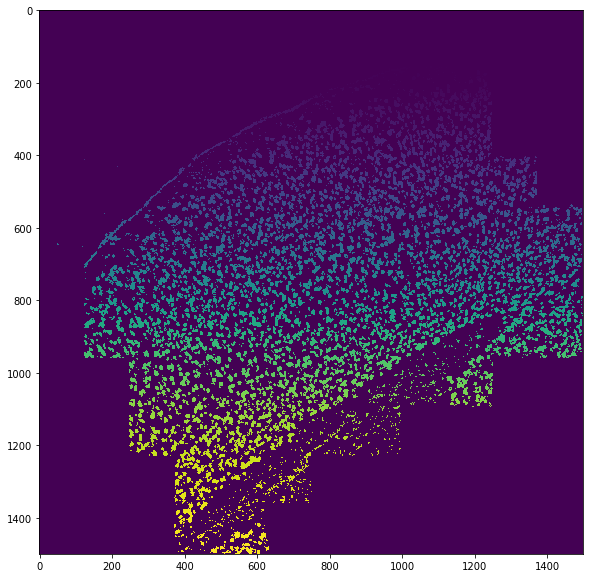

In [124]:
plot_image(res)

Drop small cells (area < 45 pixels)

In [125]:
from skimage.measure import regionprops

cells = regionprops(res)

for c in cells: 
    if c.area < 45: 
        res[res == c.label] = 0

Plot the final result

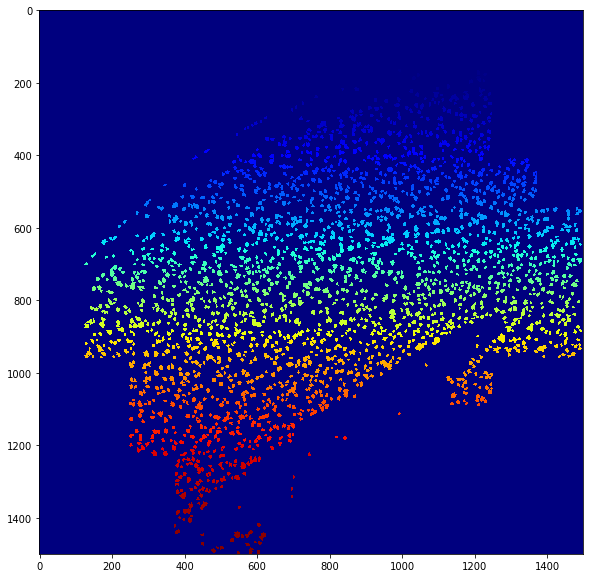

In [138]:
plot_image(res, cmap=plt.cm.jet)

Example to check my understanding of watershed. 

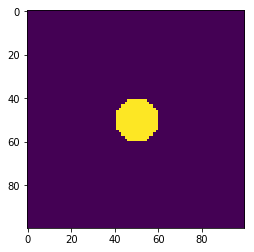

In [157]:
from skimage.draw import circle

mask = np.zeros((100, 100))
rr, cc = circle(50, 50, 10)
mask[rr, cc] = 1

img = np.zeros((100, 100))
rr, cc = circle(50, 50, 20)
img[rr, cc] = 1

dist = ndi.distance_transform_edt(img)

# get local maxima, convert those to markers
local_max = skimage.feature.peak_local_max(dist, labels=mask, indices=False)
markers = label(local_max)

res = watershed(-dist, markers=markers, mask=mask)

plt.imshow(res)